<h1 style="color:blue;text-align:center">Enforcing a uniform reference state</h1>

**{The executation time notebook is approximately 5 min (w/ Apple M1 Pro)}**

## Required theory (in brief)

For a comprehensive exploration of the theory that has been left out of this supplementary notebook, we refer the reader to the main text. For brevity, we ask the reader to recall the Gaussian likelihood model and the full posterior probability of the ensemble over $N$ replicas, which can be expressed as

$$
\begin{equation}
p(\mathbf{X},\boldsymbol{\sigma}|D) \propto \prod^{N}_{r=1} \left[ p(X_{r})\cdot \prod^{N_{d}}_{j=1} \left[ \frac{1}{\sqrt{2\pi} \sigma_{j}} \exp \left( -\frac{(d_{j} - f_{j}(\mathbf{X}))^{2}}{2\sigma_{j}^{2}}  \right)\right]^{\xi}p(\sigma_{j}) \right],
\end{equation}
$$

where $\xi$ is a scaling parameter that controls the strength of the data restraints. The uncertainty parameter $\sigma_{j} = \sqrt{(\sigma^{\text{SEM}}_{j})^{2} + (\sigma^{\text{B}}_{j})^{2}}$, which considers all sources of error.  As a consequence, the error model reflects the uncertainty in the experimental measurements, known as a Bayesian uncertainty parameter $\sigma^{\text{B}}_{j}$.

The prior distribution of uncertainties $p(\sigma_{j})$ can be modeled however, as long as the posterior is correctly normalized. This model treats $p(\sigma_{j})$ as a non-informative Jeffreys prior $(1 / \sigma_{j})$ for each data point. This model reduces to what we call the \textbf{Bayesain model} upon marginalizing out $\sigma_{j}$ and use only a single replica such that the $\sigma^{\text{SEM}} = 0$ and we are left with one Bayesian sigma $\sigma^{\text{B}}$ parameter for a particular data type.

The energy function $u = -\log p(X,\boldsymbol{\sigma}|D)$ becomes

$$
\begin{aligned}
u = \sum^{N}_{r=1} -\log \left[ \frac{\exp (-E(X_{r}))}{\sum_{X} \exp \left( -E(X)\right)}\right] + N  \left[ \sum_{j=1}^{N_{d}} - \xi\log \left( \frac{1}{\sqrt{2 \pi} \sigma_{j}} \right)+ \xi\frac{(d_{j}-f_{j}(\mathbf{X}))^{2}}{2 \sigma_{j}^{2}} - \log ( p(\sigma_{j}) ) \right],
\end{aligned}
$$



## Introduction

BICePs is able to perform objective model selection by calculating a free energy-like quantity called the BICePs score, computed as the negative logarithm of a Bayes factor comparing the total evidence of a given model against a uniform reference, marginalizing over all uncertainty. BICePs uses energies of conformational states that come from a particular force field as prior knowledge. By enforcing data restraints and evaluating the agreement between experimental obserrvables against the $\textit{forward model}$—predictions of correspondning observables using the conformational states, the BICePs score can be used to rank the strength of a given model. This technique is analogous to evaluating the free energy of turning on the prior energies ($\lambda= 0 \rightarrow 1$) in the presence of data restraints, where the reference distribution $(\lambda=0.0)$ considers the energy of applying data restraints with a uniform prior.  If these reference distributions across force fields do not strongly overlap, then certain force fields do a better job at reproducing experimental observables.


Previously, when performing model selection, BICePs assumed that the states themselves are indistinguishable across models i.e., force fields.  Unfortunately, this is not true and so when comparing ensemble averaged experimental observables to corresponding predicted observables called $\textit{the forward model}$, we find that some force fields do a better job than others. This may seem obvious, but it is difficult to determine with many states and may not be so clear.  It behoves us when performing model selection to ensure objective comparisons.

Here, we discuss several approaches (three of which will be presented in this notebook as a proof of principle).  One approach is to enforce uniform state definition by constructing a joint Markov State Model (MSM), but doing this for many different force fields leads to several complications like, loss of unique states found in particular force fields that are not found in others. Additionally, population reweighting will be biased towards the combination of force fields, resulting in states with zero population for certain models.  

Our first approach aims to enforce a uniform reference state by turning off both the prior and the data restraints to reach a minimim energy that remains constant for all models. In this framework, BICePs attempts to calculate the free energy of turning on the data restraints $\xi = 0.0 \rightarrow 1.0$ in the presence of a uniform prior ($\lambda=0.0$). Followed by determining the free energy of turning on the prior $\lambda = 0.0 \rightarrow 1.0$.  This approach is similar to an absolute free energy calculation. When using a large number of data restraints, this free energy will be larger in magnitude than the free energy of turning on the prior. 


The second approach enforces a uniform reference state by establishing a reference model that will permit the scores to be calculated relative to the reference model. The reference ensemble with the lowest energy is used as the new reference and relative free enrgy differences for all models are calaculated using MBAR. However, this approach assumes that the states across models are the same. To overcome this issue it is possible to find a mapping of conformational states or create a mixing of forward models. Note that this approach may be infeasible depending upon the circumstances. 


Alternatively, the third approach circumvents the state issue previously mentioned. Thermodynamic integration over $\xi$ (from $0 \rightarrow 1$) makes it possible to accurately estimate the free energy from a single BICePs simulation without the need of a Markov chain for each intermediate, which can be computationally expensive. 



To demonstrate how the states across models are in fact distinguishable which will result in a lack of overlap between the reference ensembles of different force fields, we  use a simple 3-state toy system with two observables for each state.  First, we formulate the problem by saying that certain force fields are inheritently able to match experimental observables better than others due to their force field parameters. So, we generate data for three distict models (force fields) and intentionally seperate the reference distributions by leaving Model$_{0}$ alone, perturbing the forward model observables for Model$_{1}$ by 1 unit and Model$_{2}$ by 2 units. In this notebook, we present a proof of principle for the "absolute" and "relative" approaches and show that over five independent trials the results are the equivalent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import biceps
from biceps.PosteriorSampler import u_kln_and_states_kn
from pymbar import MBAR
from scipy import interpolate, integrate

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
def write_noe_files(weights, x, exp, dir):
    for i in range(len(weights)):
        model = pd.read_pickle("template.noe")
        _model = pd.DataFrame()
        for j in range(len(exp)):
            model["restraint_index"], model["model"], model["exp"] = 1+j, x[i][j], exp[j]
            _model = pd.concat([_model,model], ignore_index=True)
        _model.to_pickle(dir+"/%s.noe"%i)

####### BICePs Parameters #######
nStates,Nd = 3,2
n_xis,n_lambdas,nreplicas,nsteps,swap_every,write_every=1,2,8,1000000,0,100
stat_model,data_uncertainty="Students","single"
expanded_values = [(0.0,0.00), (0.0,0.001), (0.0,0.0025), 
                   (0.0,0.01), (0.0,0.025), (0.0,0.05),
                   (0.0,0.1), (0.0,0.15), (0.0,0.20),
                   (0.0,0.25), (0.0,0.3), (0.0,0.35), (0.0,0.4),
                   (0.0,0.45), (0.0,0.5), (0.0,0.55), (0.0,0.6), 
                   (0.0,0.65), (0.0,0.7), (0.0,0.75),                    
                   (0.0,0.8), (0.0,0.85),
                   (0.0,0.9), (0.0,1.0), (1.0,1.0)]
multiprocess=1
move_state_every,move_sigma_every = 1,1
burn = 1000
lambda_values = np.linspace(0.0, 1.0, n_lambdas)
sigMin,sigMax,dsig = 0.001,100,1.02
arr = np.exp(np.arange(np.log(sigMin), np.log(sigMax), np.log(dsig)))
sigma_index = round(len(arr)*0.73)
options = [dict(stat_model=stat_model,
            sigma=(sigMin, sigMax, dsig), sigma_index=sigma_index,   
            data_uncertainty=data_uncertainty, 
            )]
print(f"nSteps of sampling: {nsteps}\nnReplicas: {nreplicas}")

####### Toy model data #######
populations = np.array([0.5, 0.3, 0.2])
energies = -np.log(populations)
forward_model_data = np.array([[1.0, 1.1],
                               [1.2, 1.3],
                               [1.4, 1.5],
                              ])
experiment = [0.0, 0.0]
# Force fields yield different populations. Here, Model1 and Model2 give 
# state0 and state1 smaller populations (higher energy).
energy_perturbations = np.array([
                        [0.00000000, 0.00000000, 0.00000000],
                        [0.00000000, 0.00000000, 0.00000000],
                        [0.00000000, 0.00000000, 0.00000000]])                        
# Perurb the 2nd distance of the forward model by for each model by [0,1,2].
# By setting these values to zero, we will find the correction virtually goes to 0.
forward_model_perturbations = [0, 1.0, 2.0] 

ensembles,trajs,logZs,results = [],[],[],[]

####### Create directories and write to files #######
dir = "results"
biceps.toolbox.mkdir(dir)
state_dir = f"{dir}/{nStates}_state_toy_model"
biceps.toolbox.mkdir(state_dir)
dir = f"{state_dir}/{nStates}_state_{Nd}_datapoints"
data_dir = dir+"/NOE"
biceps.toolbox.mkdir(data_dir)
write_noe_files(weights=energies, x=forward_model_data, exp=experiment, dir=data_dir)

input_data = biceps.toolbox.sort_data(data_dir)
print(f"Input data: {biceps.toolbox.list_extensions(input_data)}")
outdir = f'{dir}/{stat_model}_{data_uncertainty}_sigma/{nsteps}_steps_{nreplicas}_replicas_{n_lambdas}_lam__swap_every_{swap_every}'
biceps.toolbox.mkdir(outdir)

pd.DataFrame(options)

nSteps of sampling: 1000000
nReplicas: 8
Input data: ['.noe']


,stat_model,sigma,sigma_index,data_uncertainty
0,Students,"(0.001, 100, 1.02)",425,single


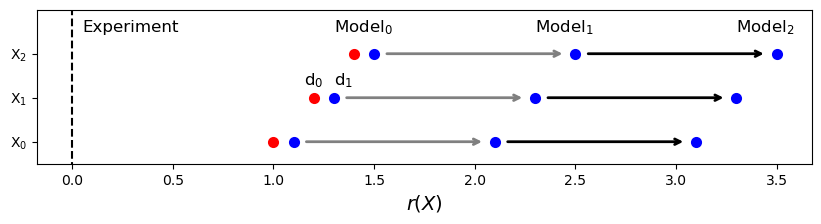

In [3]:
%matplotlib inline
figsize = (10, 2)
label_fontsize=12
legend_fontsize=10
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1, wspace=0.02)
ax1 = fig.add_subplot(gs[0,0])
axs = [ax1]
arrow_props = [dict(arrowstyle='<-', linewidth=2, color="gray"), 
               dict(arrowstyle='<-', linewidth=2, color="k")]   
axs[0].vlines(x=0, ymin=-5, ymax=5, color="k", ls="--")
axs[0].text(0.05, 2.5, 'Experiment', fontsize=12)
model_labels = [f"Model$_{i}$" for i in range(len(forward_model_perturbations))]
for i in range(len(forward_model_data)):
    for k in range(len(forward_model_data[i])):
        edge_colors = ["r", "b", "k"]
        color = biceps.toolbox.mpl_colors[::2][i]
        x = forward_model_data[i][k]
        axs[0].scatter(x, y=i, color=edge_colors[k], linewidth=2.)
        if i == 1: 
            if k == 0: axs[0].text(x-0.05, i+0.3, r"d$_{%s}$"%k, fontsize=12)  
            if k == 1: axs[0].text(x, i+0.3, r"d$_{%s}$"%k, fontsize=12)  
    for k in range(1, len(forward_model_perturbations)):
        x0 = forward_model_data[i][1]
        x1 = x0 + forward_model_perturbations[k]
        if k == 1: x0_new = x0
        else: x0_new = x0 + forward_model_perturbations[k-1]
        axs[0].annotate('', xy=(x0_new+0.05, i), xytext=(x1-0.05, i),
                        arrowprops=arrow_props[k-1])
        if i == len(forward_model_data)-1:
            axs[0].text(x0_new-0.2, i+0.5, model_labels[k-1], fontsize=12)
            if k == len(forward_model_perturbations)-1:
                axs[0].text(x1-0.2, i+0.5, model_labels[k], fontsize=12)   
        axs[0].scatter(x1, y=i, color=edge_colors[1], linewidth=2.)        
axs[0].set_ylim(-0.5,3)        
yticks = np.array(axs[0].get_yticks())
yticks = list(range(3))
ytick_labels = []
for i in range(len(yticks)):
    if yticks[i] in list(range(nStates)): ytick_labels.append(r"X$_{%s}$"%str(i))
    else: ytick_labels.append("")
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_xlabel(r"$r(X)$", fontsize=14)
axs[0].set_ylabel("", fontsize=14)
fig.savefig(f"{outdir}/models_and_data.pdf", dpi=400)

**Figure 1. Testing BICePs score corrections in three models using a simple 3-state toy system with two distances $d$ for each state.** The three models represent unique force fields having different forward model data. The quality of simulated observables vary from experimental observables due to different force field parameters. To show this, we perturb the second distance $d_{1}$ in each state for Model$_{1}$ by 1 unit and Model$_{2}$ by 2 units. 

### The first approach: Enforcing a uniform reference by turning off the data restraints and calculating the free energy of turning on the restraints $\xi = 0 \rightarrow 1$.
**{The following blocks of code for this approach will take approximately 2 min (w/ Apple M1 Pro)}**

<!--($\lambda=0,\xi=0$) $\rightarrow$ ($\lambda=0 \rightarrow \xi=1$)-->

In order to determine the change in free energy, which grows with the number of restraints, we need to simulate Markov chains for many intermediates to help bridge the two ensembles ($\lambda=0,\xi=0$) $\leftrightarrow$ ($\lambda=0, \xi=1$). 




In [4]:
# print out the values for λ and ξ used for each of the intermediates 
pd.DataFrame(expanded_values, columns=[r"$\lambda$", r"$\xi$"])

,$\lambda$,$\xi$
0,0.0,0.0000
1,0.0,0.0010
2,0.0,0.0025
3,0.0,0.0100
4,0.0,0.0250
5,0.0,0.0500
6,0.0,0.1000
7,0.0,0.1500
8,0.0,0.2000
9,0.0,0.2500


### Note that the progress bar has slight issues in the Jupyter notebook, so I set `progress=False` or `progress=0`.

In [5]:
for i in range(len(energy_perturbations)):
    
    ####### Data for i'th model #######    
    new_energies = energies + energy_perturbations[i]
    new_populations = np.exp(-new_energies)
    new_populations /= new_populations.sum()
    print(f"Prior populations: {new_populations}")
    # Shift the 2nd data point for each state by +1 for each new model
    model_perturbations = np.zeros(forward_model_data.shape)
    model_perturbations[:, 1] = model_perturbations[:, 1]+forward_model_perturbations[i]
    new_forward_model_data = forward_model_data + model_perturbations

    data_dir = dir+f"/NOE_{i}"
    biceps.toolbox.mkdir(data_dir)
    write_noe_files(weights=energies, x=new_forward_model_data, exp=experiment, dir=data_dir)
    input_data = biceps.toolbox.sort_data(data_dir)

    ####### Run MCMC #######  
    ensemble = biceps.ExpandedEnsemble(expanded_values=expanded_values, energies=new_energies)
    ensemble.initialize_restraints(input_data, options, verbose=0)
    sampler = biceps.PosteriorSampler(ensemble, nreplicas, write_every=write_every)
    sampler.sample(nsteps, attempt_lambda_swap_every=swap_every, swap_sigmas=1,
            attempt_move_state_every=move_state_every,
            attempt_move_sigma_every=move_sigma_every,
            progress=0, multiprocess=multiprocess)
    
    ####### store data #######  
    expanded_values = sampler.expanded_values 
    trajs.append([sampler.traj[k].__dict__ for k in range(len(sampler.traj))])
    
    ####### Calculate BICePs scores ####### 
    A = biceps.Analysis(sampler, outdir=outdir, progress=0)
    # get BICePs scores w/ MBAR
    BS, pops = A.f_df, A.P_dP[:,len(expanded_values[:])-1]
    print(f"Reweighted populations: {pops}\n\n")
    BS /= sampler.nreplicas
    K = len(expanded_values[:])-1
    pops_std = A.P_dP[:,2*K]
    # approximate scores w/ exponential averaging
    approx_scores = A.approximate_scores(burn)
    approx_scores["exp_avg"] /= sampler.nreplicas    
    approx_scores["BS"] = BS[:,0] # add BICePs scores to DataFrame
    results.append(approx_scores)


Prior populations: [0.5 0.3 0.2]


Time for MBAR: 4.977 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Reweighted populations: [0.61551538 0.25998901 0.12373043]


Prior populations: [0.5 0.3 0.2]


Time for MBAR: 3.182 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Reweighted populations: [0.58289365 0.27267791 0.14353018]


Prior populations: [0.5 0.3 0.2]


Time for MBAR: 4.955 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Reweighted populations: [0.56259124 0.2804795  0.15595103]




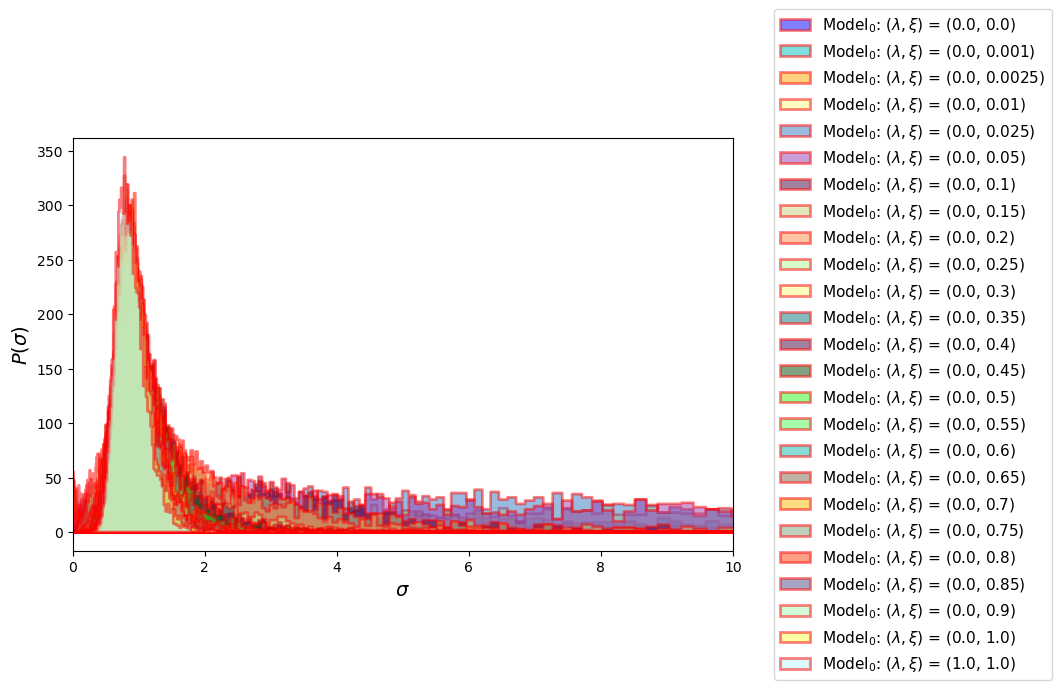

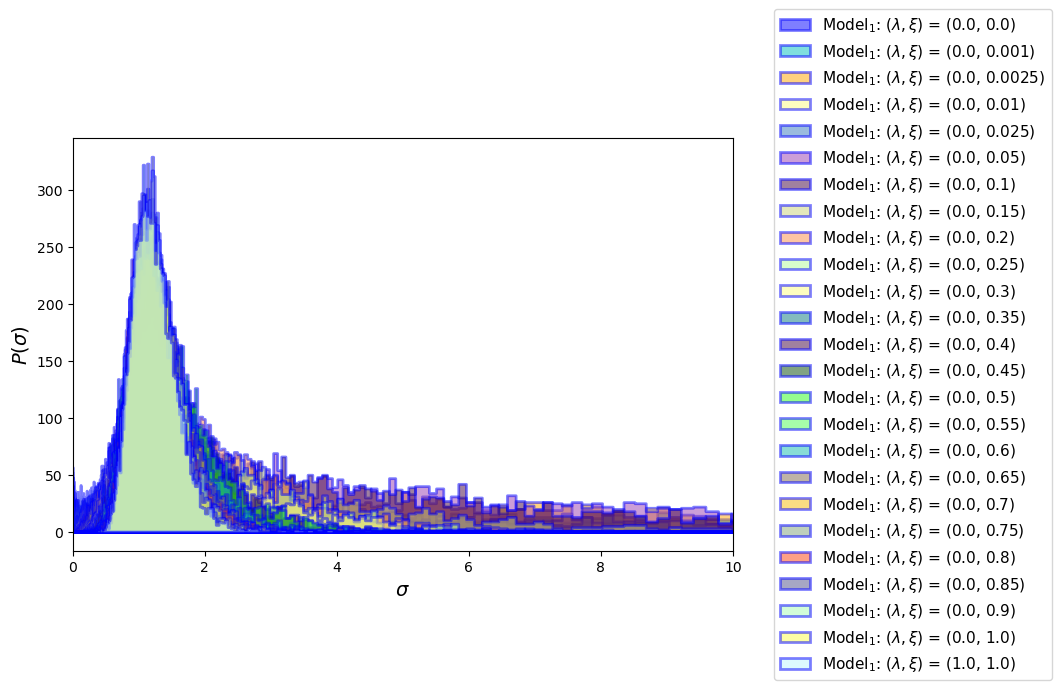

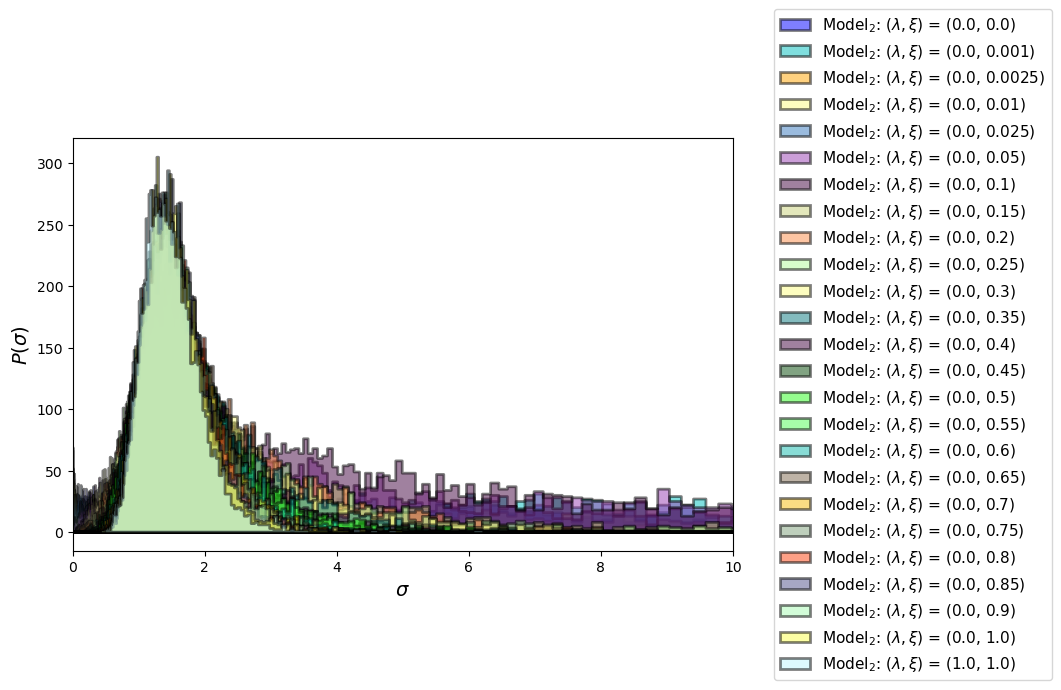

In [6]:
%matplotlib inline
for i in range(len(trajs)):
    figsize = (10, 5)
    label_fontsize=12
    legend_fontsize=10
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 1, wspace=0.02)
    ax1 = fig.add_subplot(gs[0,0])
    axs = [ax1]
    for k in range(len(trajs[i])):
        label = r"Model$_{%s}$: $(\lambda, \xi)$ = "%(i)+str(expanded_values[k])
        edge_colors = ["r", "b", "k"]
        color = biceps.toolbox.mpl_colors[::2][k]
        x = trajs[i][k]['allowed_parameters'][0]
        y = trajs[i][k]['sampled_parameters'][0]        
        axs[0].fill_between(x, y, color=color, step="pre", alpha=0.5,
                            label=label, 
                            edgecolor=edge_colors[i], 
                            linewidth=2.)
    axs[0].set_xlim(0,10)
    axs[0].set_ylabel(r"$P(\sigma)$", fontsize=14)
    axs[0].set_xlabel(r"$\sigma$", fontsize=14)
    handles, labels = axs[0].get_legend_handles_labels()
    order = list(range(len(handles)))
    axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                  loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=label_fontsize-1)
    xticks = np.array(axs[0].get_xticks())
    fig.subplots_adjust(left=0.09, bottom=0.125, top=0.95, right=0.75, wspace=0.20, hspace=0.5)
    #fig.savefig(f"{outdir}/sigma_distributions.pdf", dpi=400)

**Figure 2. Turning on the data restraints $\xi=0\rightarrow 1$ as shown by the Marginal posterior distributions of $\sigma$.**

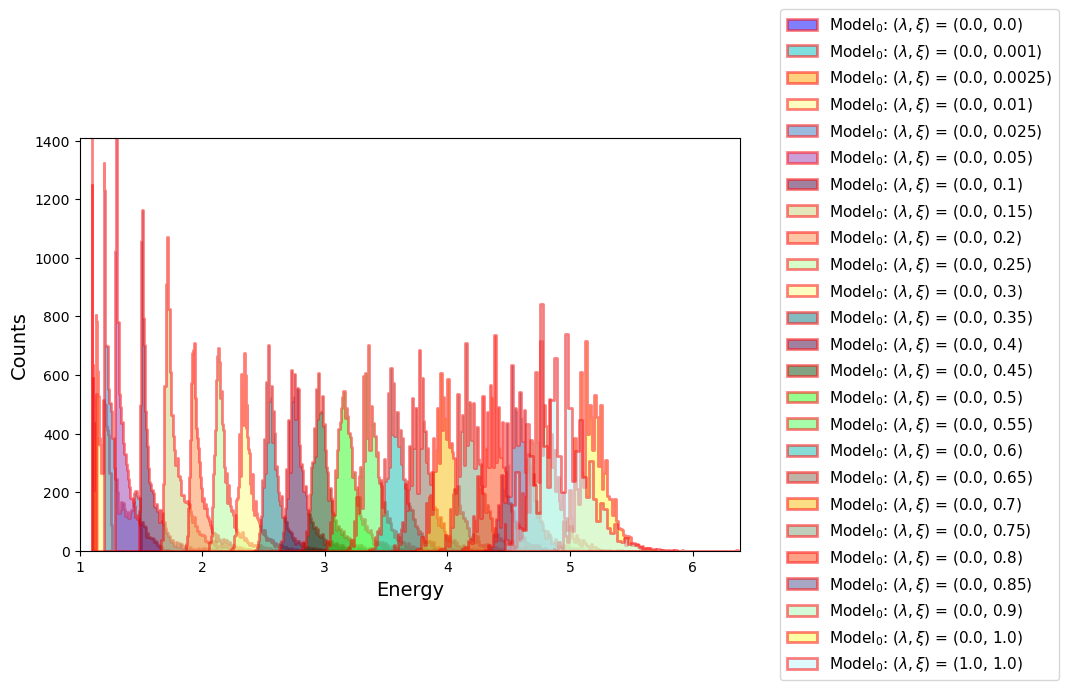

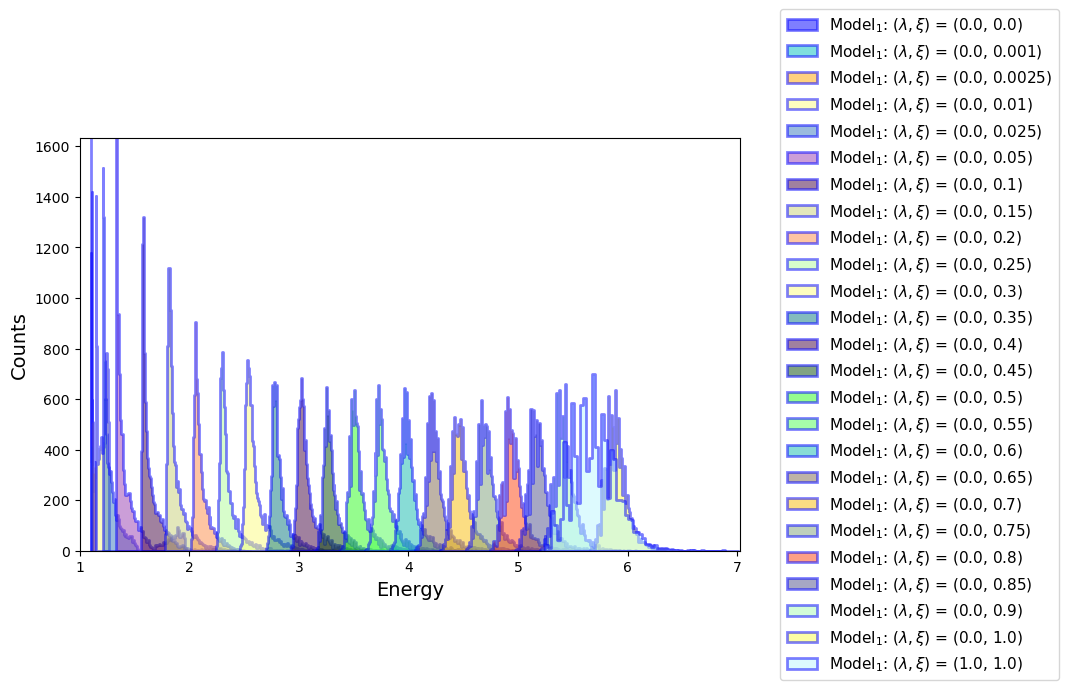

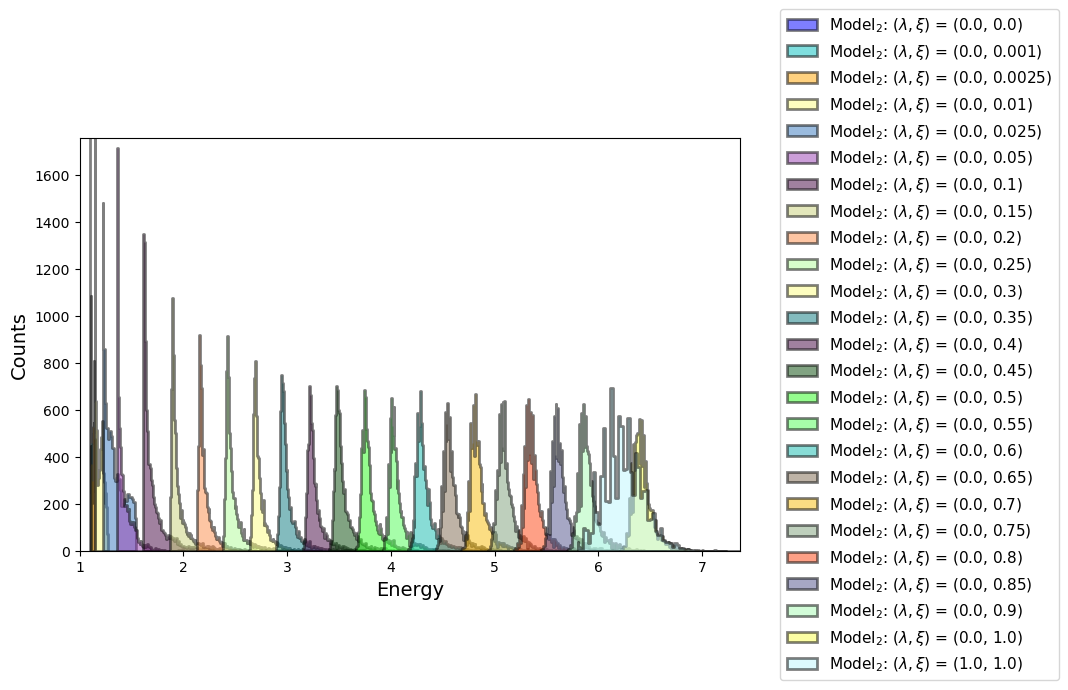

In [7]:
%matplotlib inline
for i in range(len(trajs)):
    figsize = (10, 5)
    label_fontsize=12
    legend_fontsize=10
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 1, wspace=0.02)
    ax1 = fig.add_subplot(gs[0,0])
    axs = [ax1]
    minima, maxima = 999,-999
    max_counts = 0
    for k in range(len(trajs[i])):
        x = np.array(trajs[i][k]['trajectory'], dtype=object).T[0]
        energy_dist = np.array(trajs[i][k]['trajectory'], dtype=object).T[1]
        energy_dist /= nreplicas
        energy_dist = energy_dist[burn:]
        label = r"Model$_{%s}$: $(\lambda, \xi)$ = "%(i)+str(expanded_values[k])
        edge_colors = ["r", "b", "k"]
        color = biceps.toolbox.mpl_colors[::2][k]
        counts, bins = np.histogram(energy_dist, bins="auto")
        if (k == 0) and (len(counts) == 1):
            axs[0].fill_between([energy_dist[0]], [len(energy_dist)], color=color, step="pre", alpha=0.5,
                                label=label, edgecolor=edge_colors[i], 
                                linewidth=2.)                        
        else:
            x,y = np.array(bins[:-1], dtype=float), np.array(counts, dtype=int)
            axs[0].fill_between(x, y, color=color, step="pre", alpha=0.5,
                                label=label, edgecolor=edge_colors[i], 
                                linewidth=2.)            
            if energy_dist.min() < minima: minima = energy_dist.min()
            if energy_dist.max() > maxima: maxima = energy_dist.max()                
            if counts.max() > max_counts: max_counts = counts.max()
    axs[0].set_xlim(left=minima, right=maxima)
    axs[0].set_ylim(bottom=0, top=max_counts)
    axs[0].set_xlabel("Energy", fontsize=14)
    axs[0].set_ylabel("Counts", fontsize=14)    
    handles, labels = axs[0].get_legend_handles_labels()
    order = list(range(len(handles)))
    axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                  loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=label_fontsize-1)
    xticks = np.array(axs[0].get_xticks())
    axs[0].set_xticks(np.arange(xticks[0], xticks[-1], 1))
    fig.subplots_adjust(left=0.09, bottom=0.125, top=0.95, right=0.75, wspace=0.20, hspace=0.5)
    #fig.savefig(f"{outdir}/energy_distributions.pdf", dpi=400)

**Figure 3. Many intermediate ensembles are required to bridge the gap for $\xi=0 \rightarrow 1$ as shown by the $-\log P$ energy distributions.**

Note that some of the distributions are noisy with peaks. This is attributed to a low number of states with very few data points. Sampling for a longer time does not help. 


In [8]:
extended = []
for i in range(len(results)):
    res = results[i]
    ref = res.iloc[np.where((res["lambda"]==0.0) & (res["xi"]==0.0))[0]]
    data_rest = res.iloc[np.where((res["lambda"]==0.0) & (res["xi"]==1.0))[0]]
    full = res.iloc[np.where(res["lambda"]==1.0)[0]]
    _df = pd.concat([ref,data_rest,full])
    _df["Model"] = np.ones(len(_df), dtype=int)*i
    extended.append(_df)
extended = pd.concat(extended).reset_index()
extended.drop(["index"], axis=1,inplace=True)
abs_FE_ref_lam0 = extended.iloc[np.where((extended["lambda"]==0.0) & (extended["xi"]==1.0) &
                                    (extended["Model"]==0))[0]]["BS"].to_numpy()
extended

,lambda,xi,exp_avg,approx_score,BS,Model
0,0.0,0.0,1.098612,0.000000,0.000000,0
1,0.0,1.0,5.155932,4.057320,4.466380,0
2,1.0,1.0,4.795112,3.696500,4.369670,0
3,0.0,0.0,1.098612,0.000000,0.000000,1
4,0.0,1.0,5.881816,4.783204,5.158920,1
5,1.0,1.0,5.583510,4.484897,5.089661,1
6,0.0,0.0,1.098612,0.000000,0.000000,2
7,0.0,1.0,6.409185,5.310573,5.676923,2
8,1.0,1.0,6.143223,5.044611,5.623649,2


### The second approach: Enforcing a uniform reference by establishing a reference model, where BICePs scores are relative to this reference model
**{The following blocks of code for this approach will take approximately 15 sec (w/ Apple M1 Pro)}**

In a real system with a large number of data restraints, this approach will consume far less computational resources. Theoretically, both approaches produce the same results. Later, we will convert to an absolute scale relative to the reference model to compare the accuracy.

In [9]:
ensembles,trajs,logZs,results = [],[],[],[]
for i in range(len(energy_perturbations)):
    
    ####### Data for i'th model #######    
    new_energies = energies + energy_perturbations[i]
    new_populations = np.exp(-new_energies)
    new_populations /= new_populations.sum()
    print(f"Prior populations: {new_populations}")
    # Shift the 2nd data point for each state by +1 for each new model
    model_perturbations = np.zeros(forward_model_data.shape)
    model_perturbations[:, 1] = model_perturbations[:, 1]+forward_model_perturbations[i]
    new_forward_model_data = forward_model_data + model_perturbations

    data_dir = dir+f"/NOE_{i}"
    biceps.toolbox.mkdir(data_dir)
    write_noe_files(weights=energies, x=new_forward_model_data, exp=experiment, dir=data_dir)
    input_data = biceps.toolbox.sort_data(data_dir)

    ####### Run MCMC #######  
    ensemble = biceps.ExpandedEnsemble(lambda_values=lambda_values, energies=new_energies)
    ensemble.initialize_restraints(input_data, options, verbose=0)
    sampler = biceps.PosteriorSampler(ensemble, nreplicas, write_every=write_every)
    sampler.sample(nsteps, progress=0, multiprocess=multiprocess)
    
    ####### store data #######  
    expanded_values = sampler.expanded_values 
    # get ensemble and normalization
    for k in range(len(sampler.ensembles)):
        ensembles.append(sampler.ensembles[k])
        logZs.append(sampler.logZs[k])
    # get trajectories
    trajs.append([sampler.traj[k].__dict__ for k in range(len(sampler.traj))])

    ####### Calculate BICePs scores #######  
    A = biceps.Analysis(sampler, outdir=outdir, progress=0)
    # get BICePs scores w/ MBAR
    BS, pops = A.f_df, A.P_dP[:,len(expanded_values[:])-1]
    print(f"Reweighted populations: {pops}\n\n")
    K = len(expanded_values[:])-1
    pops_std = A.P_dP[:,2*K]
    # approximate scores w/ exponential averaging
    approx_scores = A.approximate_scores(burn)
    approx_scores["exp_avg"] /= sampler.nreplicas    
    approx_scores["BS"] = BS[:,0]/sampler.nreplicas # add BICePs scores to DataFrame
    results.append(approx_scores)

Prior populations: [0.5 0.3 0.2]
Time for MBAR: 0.402 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Reweighted populations: [0.61502383 0.2607474  0.12416533]


Prior populations: [0.5 0.3 0.2]
Time for MBAR: 0.046 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Reweighted populations: [0.58030515 0.27496276 0.14465878]


Prior populations: [0.5 0.3 0.2]
Time for MBAR: 0.042 s
Writing results/3_state_toy_model/3_state_2_datapoints/Students_single_sigma/1000000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing results/3_state_toy_mode

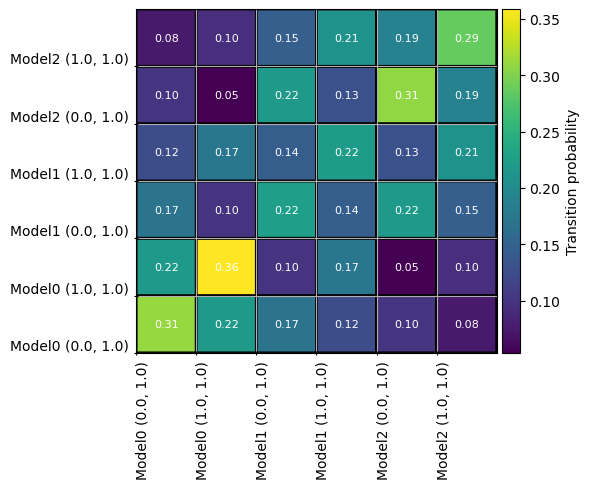

In [10]:
####### Calculate BICePs #######     
trajectories = np.concatenate(trajs)
K = len(ensembles)   # number of thermodynamic ensembles
N_k = np.array( [len(trajectories[i]['trajectory']) for i in range(len(ensembles))] )
u_kln, states_kn, Nr_array = u_kln_and_states_kn(ensembles, trajectories,
                nstates=len(energies), logZs=logZs, progress=0)
mbar = MBAR(u_kln, N_k)
_results = mbar.compute_free_energy_differences(uncertainty_method='approximate', return_theta=True)
Deltaf_ij, dDeltaf_ij, Theta_ij = _results["Delta_f"], _results["dDelta_f"], _results["Theta"]
beta = 1.0 # keep in units kT
f_df = np.zeros( (len(ensembles), 2) )  # first column is Deltaf_ij[0,:], second column is dDeltaf_ij[0,:]
Deltaf_ij /= nreplicas
f_df[:,0] = Deltaf_ij[0,:]  # biceps score
f_df[:,1] = dDeltaf_ij[0,:] # biceps score std

# NOTE: https://pymbar.readthedocs.io/en/master/mbar.html#pymbar.MBAR.compute_overlap
overlap = mbar.compute_overlap()
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust the figsize as desired
im = ax.pcolor(overlap['matrix'], edgecolors='k', linewidths=2)

df = pd.concat(results)
model_ids = [i for i in range(len(trajs)) for k in range(len(trajs[i]))]
df["Model"] = model_ids
df["FF"] = [f"Model{model_ids[m]} "+f"{(lam,xi)}"
            for m,(lam,xi) in enumerate(zip(df["lambda"].to_numpy(),df["xi"].to_numpy()))]
ff = df["FF"].to_numpy()



col_name = "BS w/ ref=Model"
df = pd.concat(results)
model_ids = [i for i in range(len(trajs)) for k in range(len(trajs[i]))]
df["Model"] = model_ids
df[col_name+"0"] = f_df[:,0]
df.to_csv(f"{outdir}/scores.csv", index=False)
columns = [col for col in df.columns.to_list() if col_name in col]
lam0 = df.iloc[np.where(df["lambda"]==0.0)[0]]
lam0 = lam0[columns]
lam1 = df.iloc[np.where(df["lambda"]==1.0)[0]]
lam1 = lam1[columns]
values = []
for i in range(len(lam0)):
    values.append(lam0.to_numpy()[i]+abs_FE_ref_lam0)
    values.append(lam1.to_numpy()[i]+abs_FE_ref_lam0)
df["Abs. BS w/ ref=Model0"] = np.array(values)
indices = np.where((extended["lambda"]==0.0) & (extended["xi"]==0.0))[0]
df["Abs. BS"] = extended.iloc[[i for i in range(len(extended)) if i not in indices]]["BS"].to_numpy()


                                                                                                  
# Add annotations
for i in range(len(overlap['matrix'])):
    for j in range(len(overlap['matrix'][i])):
        value = overlap['matrix'][i][j]
        if value > 0.01:
            text_color = 'white' if value < 0.5 else 'black'
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=text_color,
                    fontsize=8)  # Adjust fontsize as desired
ax.set_xticks(np.array(list(range(len(ff)))))
ax.set_yticks(np.array(list(range(len(ff)))))
ax.tick_params(axis='x', direction='inout')
ax.tick_params(axis='y', direction='inout')
ax.grid()
                                                                                                  
try:
    ax.set_xticklabels([str(tick) for tick in ff], rotation=90)
    ax.set_yticklabels([str(tick) for tick in ff])
except Exception as e:
    print(e)
                                                                                                  
ax.set_xticklabels(ax.get_xticklabels(), ha='left')
ax.set_yticklabels(ax.get_yticklabels(), va='bottom')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label("Transition probability")  # Set the colorbar label
fig.tight_layout()
#fig.savefig(f"{outdir}/{stat_model}_{nstates}_scores_trial_{trial}_contour.png")
#fig

**Figure 4. The overlap between thermodynamic states is strong and our free energy predictions are reliable.**

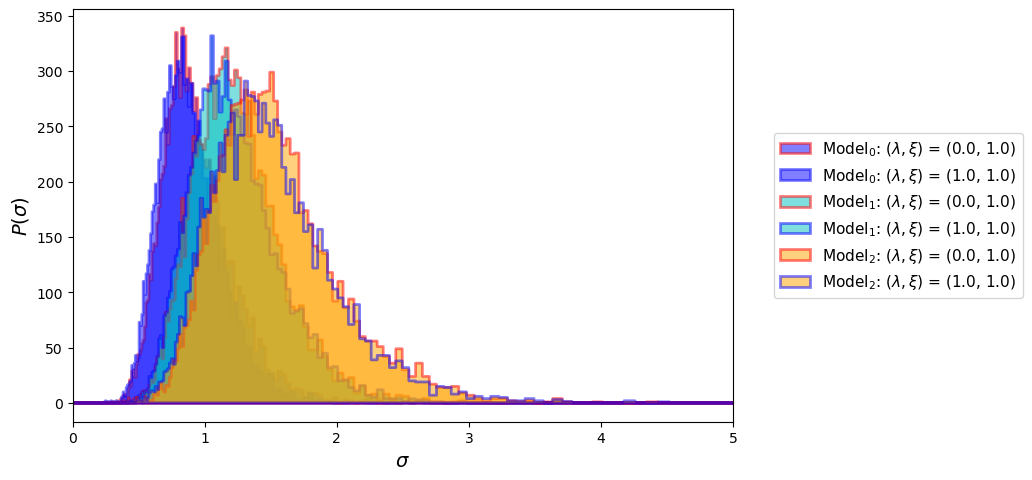

In [11]:
%matplotlib inline
figsize = (10, 5)
label_fontsize=12
legend_fontsize=10
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1, wspace=0.02)
ax1 = fig.add_subplot(gs[0,0])
axs = [ax1]

for i in range(len(trajs)):
    for k in range(len(trajs[i])):
        label = r"Model$_{%s}$: $(\lambda, \xi)$ = "%(i)+str(expanded_values[k])
        edge_colors = ["r", "b", "k"]
        color = biceps.toolbox.mpl_colors[::2][i]
        x = trajs[i][k]['allowed_parameters'][0]
        y = trajs[i][k]['sampled_parameters'][0]        
        axs[0].fill_between(x, y, color=color, step="pre", alpha=0.5,
                            label=label, edgecolor=edge_colors[k], linewidth=2.)
axs[0].set_xlim(0,5)
axs[0].set_ylabel(r"$P(\sigma)$", fontsize=14)
axs[0].set_xlabel(r"$\sigma$", fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()
order = list(range(len(handles)))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=label_fontsize-1)
xticks = np.array(axs[0].get_xticks())
fig.subplots_adjust(left=0.09, bottom=0.125, top=0.95, right=0.75, wspace=0.20, hspace=0.5)
fig.savefig(f"{outdir}/sigma_distributions.pdf", dpi=400)

**Figure 5. Marginal posterior distributions of $\sigma$ reflect the uncertainty of the data restraints for the three models.**

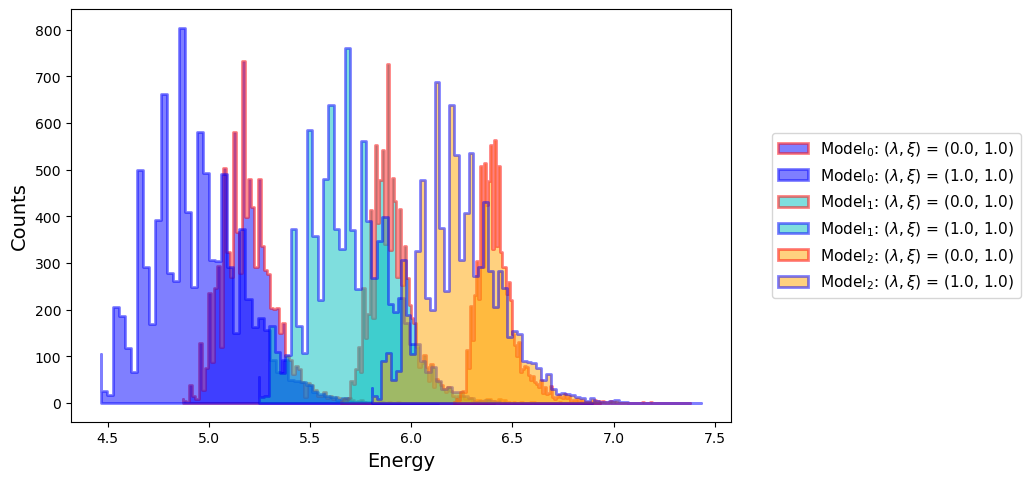

In [12]:
%matplotlib inline
figsize = (10, 5)
label_fontsize=12
legend_fontsize=10
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1, wspace=0.02)
ax1 = fig.add_subplot(gs[0,0])
axs = [ax1]

for i in range(len(trajs)):
    for k in range(len(trajs[i])):
        x = np.array(trajs[i][k]['trajectory'], dtype=object).T[0]
        energy_dist = np.array(trajs[i][k]['trajectory'], dtype=object).T[1]
        energy_dist /= nreplicas
        energy_dist = energy_dist[burn:]
        label = r"Model$_{%s}$: $(\lambda, \xi)$ = "%(i)+str(expanded_values[k])
        edge_colors = ["r", "b", "k"]
        color = biceps.toolbox.mpl_colors[::2][i]
        counts, bins = np.histogram(energy_dist, bins="auto")
        x,y = np.array(bins[:-1], dtype=float), np.array(counts, dtype=int)
        axs[0].fill_between(x, y, color=color, step="pre", alpha=0.5,
                            label=label, edgecolor=edge_colors[k], linewidth=2.)

axs[0].set_xlabel("Energy", fontsize=14)
axs[0].set_ylabel("Counts", fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()
order = list(range(len(handles)))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=label_fontsize-1)
xticks = np.array(axs[0].get_xticks())
fig.subplots_adjust(left=0.09, bottom=0.125, top=0.95, right=0.75, wspace=0.20, hspace=0.5)
fig.savefig(f"{outdir}/energy_distributions.pdf", dpi=400)

**Figure 6. Displaying the overlap between the the $-\log P$ energy distributions.** Energy distributions for the three models show clear seperation in the reference ensembles ($\lambda=0.0$; red outline).  Model improvement is made by including prior knowledge ($\lambda=1.0$) as shown in the reweighted ensembles (blue outline). 

Note that some of the distributions are noisy with peaks. This is attributed to a low number of states with very few data points. Sampling for a longer time does not change this artifact. 

## The third approach: $\xi$-integration
**{The following blocks of code for this approach will take approximately 15 sec (w/ Apple M1 Pro)}**


Here, we perform a "thermodynamic integration"-like approach over $\xi$ (from $\xi = 0 \rightarrow 1$), which enables us to estimate the absolute free energy of the data restraints without having to assume that the states between models are the same. This approach can sample all of the intermediates necessary to bridge the two thermodynamic endpoints in a single BICePs calculation. However, thermodynamic integration typically requires the calculation of $\langle\frac{\partial u}{\partial\xi}\rangle$, where this statistical average equals the restraint energy for a particular BICePs likelihood function. Then, by integrating over the entire range of $\xi$ **using MBAR** gives the score for ($\lambda=0, \xi =  0 \rightarrow 1$). The free energy difference between $(\lambda=0, \xi =  0) \rightarrow (\lambda=0, \xi = 1.0)$ is

$$
\hat{g}_k = -\ln \left( \sum_{j=1}^{K} \sum_{n=1}^{N_j} \frac{\exp \left[ -u_{j}(x_{jn}) \right]}{\sum_{k=1}^{K} N_k \exp \left[ \hat{g}_k - u_{k}(x_{jn}) \right]} \right),
$$

where $u_j(x_{jn})$ is the reduced potential for the $n$-th sample from state $j$, $N_j$ is the number of samples in state $j$. $K$ is the number of thermodynamic states in your system (here, it’s the number of discrete $\xi$ states from 0.0 to 1.0), and $\hat{g}_k$ is the free energy estimate for thermodynamic state $k$.

We generate 11 thermodynamic ensembles by ratcheting down $\xi$ in increments of 0.1 over the course of the trajectory. To increase the accuracy of this calculation, we use MBAR to calcuate the free energy of going from $\xi=0$ to $\xi=1$.


$$
f_{\xi=0 \rightarrow 1} = \hat{g}_{\xi=1} - \hat{g}_{\xi=0}
$$


In [13]:
_scores = []
figs = []
ensembles,trajs, matrices = [],[],[]
for i in range(len(energy_perturbations)):
    
    ####### Data for i'th model #######    
    new_energies = energies + energy_perturbations[i]
    new_populations = np.exp(-new_energies)
    new_populations /= new_populations.sum()
    print(f"Prior populations: {new_populations}")
    # Shift the 2nd data point for each state by +1 for each new model
    model_perturbations = np.zeros(forward_model_data.shape)
    model_perturbations[:, 1] = model_perturbations[:, 1]+forward_model_perturbations[i]
    new_forward_model_data = forward_model_data + model_perturbations

    data_dir = dir+f"/NOE_{i}"
    biceps.toolbox.mkdir(data_dir)
    write_noe_files(weights=energies, x=new_forward_model_data, exp=experiment, dir=data_dir)
    input_data = biceps.toolbox.sort_data(data_dir)

    burn = 10000
    num_xi_values = 11
    change_xi_every = round(nsteps/num_xi_values)
    dXi = 1 / (num_xi_values - 1)

    ####### Run MCMC #######
    ensemble = biceps.ExpandedEnsemble(lambda_values=[lambda_values[0]], energies=new_energies)
    ensemble.initialize_restraints(input_data, options, verbose=0)
    sampler = biceps.PosteriorSampler(ensemble, nreplicas, write_every=write_every,
            change_xi_every=change_xi_every, dXi=dXi, xi_integration=1)
    sampler.sample(nsteps, attempt_lambda_swap_every=swap_every, swap_sigmas=1,
            burn=burn, progress=1, multiprocess=multiprocess)
    
    # get ensemble and normalization
    for k in range(len(sampler.ensembles)):
        ensembles.append(sampler.ensembles[k])
        logZs.append(sampler.logZs[k])
    # get trajectories
    trajs.append([sampler.traj[k].__dict__ for k in range(len(sampler.traj))])    
   
    ti_info = sampler.ti_info
    ####### Calculate BICePs scores ####### 
    mbar = sampler.integrate_xi_ensembles(multiprocess=0, progress=0)
    overlap = mbar.compute_overlap()
    overlap_matrix = overlap["matrix"]
    matrices.append(overlap_matrix)
    _results = mbar.compute_free_energy_differences(uncertainty_method='approximate', return_theta=True)
    Deltaf_ij, dDeltaf_ij, Theta_ij = _results["Delta_f"], _results["dDelta_f"], _results["Theta"]
    f_df = np.zeros( (len(overlap_matrix), 2) )  # first column is Deltaf_ij[0,:], second column is dDeltaf_ij[0,:]
    f_df[:,0] = Deltaf_ij[0,:]  # NOTE: biceps score
    f_df[:,1] = dDeltaf_ij[0,:] # NOTE: biceps score std
    BS = -f_df[:,0]/sampler.nreplicas
    _scores.append(BS[-1])
    A = biceps.Analysis(sampler, outdir=outdir, MBAR=False)
    figs.append(A.plot_energy_trace())


Prior populations: [0.5 0.3 0.2]
 ██████████████████████████████▏ 100.0% [10000/10000 | 204.3 kHz | 1 | 0s | 0s] Burn 



Prior populations: [0.5 0.3 0.2]
 ██████████████████████████████▏ 100.0% [10000/10000 | 202.7 kHz | 1 | 0s | 0s] Burn 

Prior populations: [0.5 0.3 0.2]
 ██████████████████████████████▏ 100.0% [10000/10000 | 204.6 kHz | 1 | 0s | 0s] Burn 



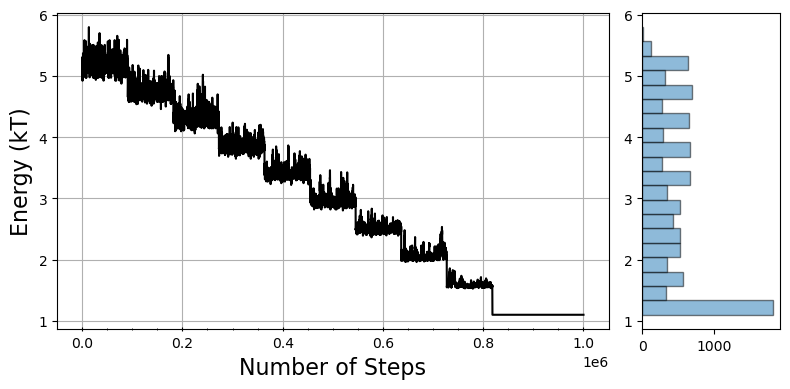

In [14]:
figs[0][0][0]

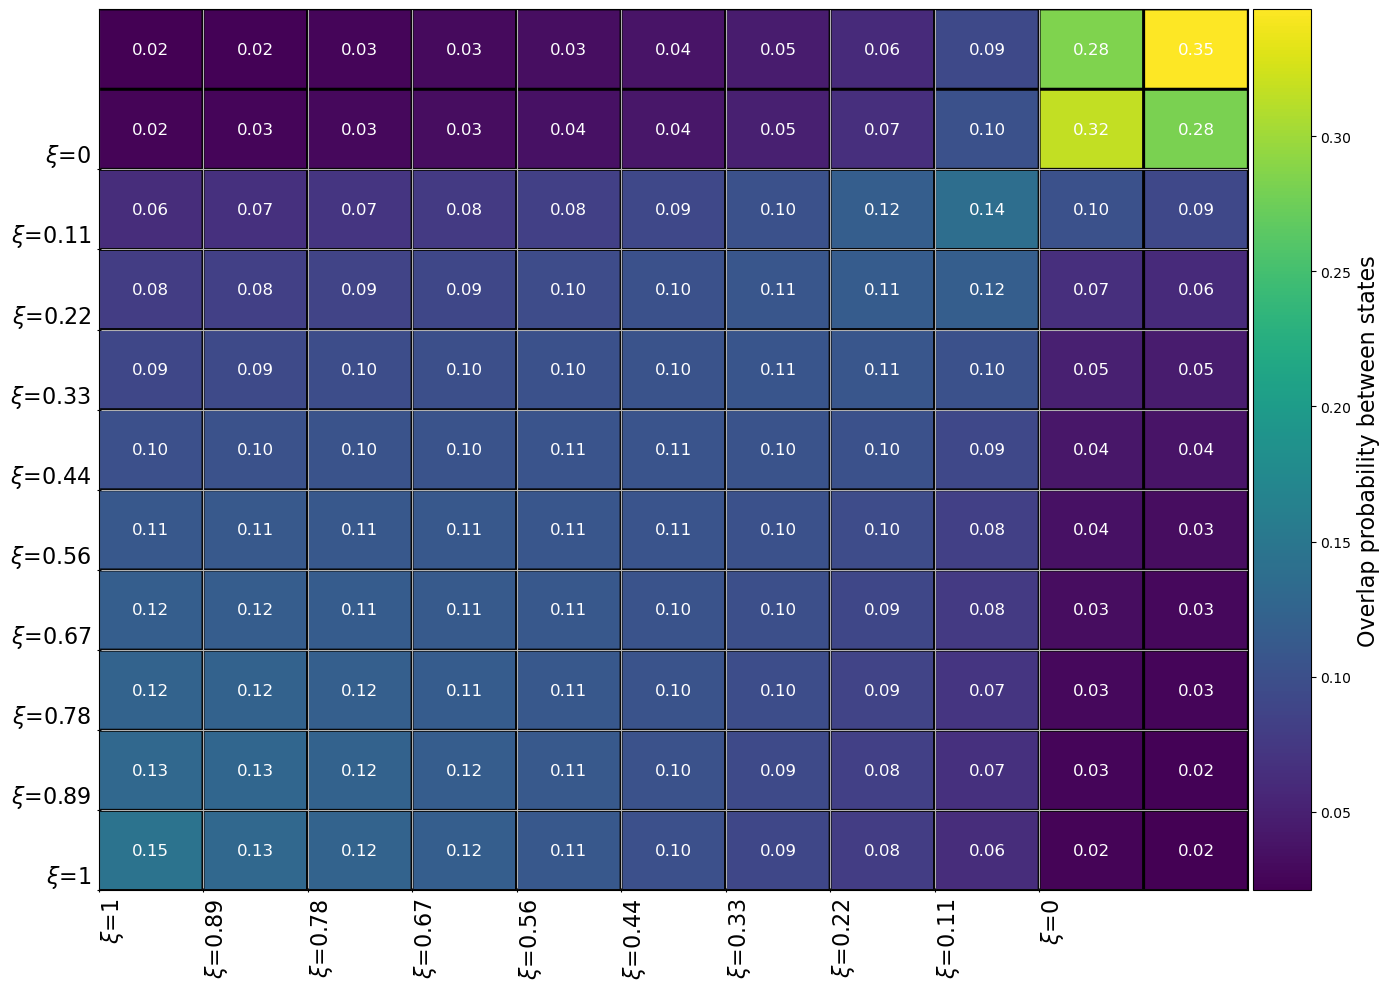

In [15]:
overlap_matrix = matrices[0]

force_constants = [r"$\xi$=%0.2g"%val for val in np.array(ti_info[0]).T[1]]
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figsize as desired
im = ax.pcolor(overlap_matrix, edgecolors='k', linewidths=2)

# Add annotations
for i in range(len(overlap_matrix)):
    for j in range(len(overlap_matrix[i])):
        value = overlap_matrix[i][j]
        if value > 0.01:
            text_color = 'white' if value < 0.5 else 'black'
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=text_color,
                    fontsize=12)  # Adjust fontsize as desired
ax.set_xticks(np.array(list(range(len(force_constants)))))
ax.set_yticks(np.array(list(range(len(force_constants)))))
ax.tick_params(axis='x', direction='inout')
ax.tick_params(axis='y', direction='inout')
ax.grid()

try:
    ax.set_xticklabels([str(tick) for tick in force_constants], rotation=90, size=16)
    ax.set_yticklabels([str(tick) for tick in force_constants], size=16)
except Exception as e:
    print(e)

ax.set_xticklabels(ax.get_xticklabels(), ha='left')
ax.set_yticklabels(ax.get_yticklabels(), va='bottom')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label("Overlap probability between states", size=16)  # Set the colorbar label
fig.tight_layout()
fig.savefig(f"{outdir}/contour.png")



$$
\text{Absolute free energy} = \text{Relative free energy} + \text{Absolute free energy of the reference state}
$$


In [16]:
col_name = "BS"
columns = [col for col in df.columns.to_list() if col_name in col]
lam0 = df.iloc[np.where(df["lambda"]==0.0)[0]]
lam0 = lam0[columns]
lam1 = df.iloc[np.where(df["lambda"]==1.0)[0]]
lam1 = lam1[columns]

values = []
for i in range(len(lam0)):
    values.append((lam0.to_numpy()[i]+_scores[i])[0])
    values.append((lam1.to_numpy()[i]+_scores[i])[0])

df["Abs. BS (xi integration)"] = values
#df.to_csv(f"{outdir}/trial0.csv")
df

,lambda,xi,exp_avg,approx_score,BS,Model,BS w/ ref=Model0,Abs. BS w/ ref=Model0,Abs. BS,Abs. BS (xi integration)
0,0.0,1.0,5.156530,0.000000,0.000000,0,0.000000,4.466380,4.466380,4.357959
1,1.0,1.0,4.799197,-0.357333,-0.095797,0,-0.096158,4.370222,4.369670,4.262162
0,0.0,1.0,5.883449,0.000000,0.000000,1,0.685479,5.151860,5.158920,5.151383
1,1.0,1.0,5.585453,-0.297996,-0.068368,1,0.616975,5.083355,5.089661,5.083014
0,0.0,1.0,6.405452,0.000000,0.000000,2,1.187582,5.653962,5.676923,5.636733
1,1.0,1.0,6.145702,-0.259750,-0.054801,2,1.133314,5.599695,5.623649,5.581931


**Table 1. Calculating the BICePs scores for the three models while accounting for the overlap in the distributions.**  Typically, BICePs scores are calculated using MBAR (BS), which can be viewed as the free energy difference of turning on the prior ($\lambda=0 \rightarrow \lambda=1$). This can be approximated using exponential averaging (approx_score), but this approach will suffer in accuracy if the distributions do not strongly overlap. The "BS w/ ref=Model0" accounts for seperation in the reference ensembles ($\lambda=0.0$) by throwing all of the ensembles inside MBAR using the lowest energy reference ensemble as the reference state. We can then take this relative score and add the absolute BICePs (Abs. BS) score of the reference state to get it on the same scale (Abs. BS w/ ref=Model0) to compare the two approaches. Lastly, we show how thermodynamic integration (TI) can achieve accurate/reliable absolute free energy estimates with little effort.

## Optimizing the $\xi$-values before integrating over $\xi$

## Optimizing $\xi$ values for increased overlap and higher accuracy in predictions

The accuracy of the BICePs score depends on converged sampling and sufficient thermodynamic overlap of intermediates ($\xi= 0\rightarrow 1$) in the BICePs computation. To ensure strong overlap, we optimize the $\xi$-values by spacing ensembles equidistantly in thermodynamic length, employing a strategy akin to the "thermodynamic trailblazing" method proposed by Rizzi et al. Our approach is facilitated by a custom optimization algorithm called *pylambdaopt*.

The optimization process is a two-step process:
First, a preliminary BICePs calculation is performed using provisional $\xi$-values, yielding estimates of the thermodynamic length $| \ell(\xi_{n+1}) - \ell(\xi_{n}) |$ for each pair of intermediates\cite{sivak2012thermodynamic,shenfeld2009minimizing}, derived from the variance in distributions $p(\Delta u_{n,n+1})$, where $\Delta u_{n,n+1} = u_{n+1} - u_n$ represents the change in the (reduced) BICePs energy incurred by bringing a sample from thermodynamic ensemble $n$ to thermodynamic ensemble $n+1$.

Second, cubic spline fitting is employed to derive a smooth and differentiable function $\ell(\xi)$ that accurately interpolates the computed $\ell(\xi_i)$. Optimization through steepest-descent minimization is then applied to determine new $\xi_i^*$ values that minimize the loss function $\mathcal{L} = \sum_n | \ell(\xi_{n+1}) - \ell(\xi_n) |^2$. This results in $\xi_i^*$ values uniformly spaced in terms of thermodynamic length, thus maximizing the thermodynamic overlap between adjacent ensembles and enhancing the precision of free energy calculations. These optimized $\xi_i^*$ values are subsequently used in production runs. An illustration of the $\xi$-values pre- and post-optimization is depicted in Figure \ref{fig:xi_optimization}. Refer to figures \ref{fig:overlap_before}\&\ref{fig:overlap_after} for overlap matrices pre- and post- optimization.







Prior populations: [0.5 0.3 0.2]
 ██████████████▉               ▏ 50.0% [ 500/1001 | 112.1 kHz | 1 | 0s | 0s] u_kln 


O_(0,1), O_(1,0) = 0.13421584191546457, 0.13421584191546457
O_(1,2), O_(2,1) = 0.12624950784351643, 0.12624950784351643
O_(2,3), O_(3,2) = 0.11916677052830703, 0.11916677052830703
O_(3,4), O_(4,3) = 0.11381419325991028, 0.11381419325991028
O_(4,5), O_(5,4) = 0.11028071638307775, 0.11028071638307775
O_(5,6), O_(6,5) = 0.10912789609355322, 0.10912789609355322
O_(6,7), O_(7,6) = 0.11255541885586863, 0.11255541885586863
O_(7,8), O_(8,7) = 0.12907534323444825, 0.12907534323444825
O_(8,9), O_(9,8) = 0.17746523044377124, 0.1792559996712563
No more attempts...
You might want to consider optimizing xi-values.
[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
[ 0.          8.94724236 13.92168693 15.82250758 17.07202112 18.14862708
 19.01721072 19.73419809 20.32426954 21.0431946 ]
 ██████████████████████████████▏ 100.0% [1001/1001 | 117.6 kHz | 1 | 0s | 0s] u_kln 
O_(0,1), O_(1

O_(0,1), O_(1,0) = 0.13650205578176478, 0.13650205578176478
O_(1,2), O_(2,1) = 0.13019649080327134, 0.13019649080327134
O_(2,3), O_(3,2) = 0.12392403672952544, 0.12392403672952544
O_(3,4), O_(4,3) = 0.11895508461180973, 0.11895508461180973
O_(4,5), O_(5,4) = 0.11577243707464127, 0.11577243707464127
O_(5,6), O_(6,5) = 0.11553993790994635, 0.11553993790994635
O_(6,7), O_(7,6) = 0.1214678712981238, 0.1214678712981238
O_(7,8), O_(8,7) = 0.140892241500797, 0.140892241500797
O_(8,9), O_(9,8) = 0.16941941616179237, 0.17112899654687605
No more attempts...
You might want to consider optimizing xi-values.
[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
[ 0.         15.45002362 20.83011653 23.57687727 25.22150773 26.45983149
 27.42949523 28.20176487 28.83219946 29.57510994]
 ██████████████████████████████▏ 100.0% [1001/1001 | 91.0 kHz | 5 | 0s | 0s] u_kln 
O_(0,1), O_(1,0) = 

 ██████████████▉               ▏ 50.0% [ 500/1001 | 90.3 kHz | 1 | 0s | 0s] u_kln 


O_(0,1), O_(1,0) = 0.12899949471950267, 0.12899949471950267
O_(1,2), O_(2,1) = 0.12411025568585374, 0.12411025568585374
O_(2,3), O_(3,2) = 0.11860431930660341, 0.11860431930660341
O_(3,4), O_(4,3) = 0.11374006257516193, 0.11374006257516193
O_(4,5), O_(5,4) = 0.10982410978667037, 0.10982410978667037
O_(5,6), O_(6,5) = 0.10781582562656869, 0.10781582562656869
O_(6,7), O_(7,6) = 0.11043911806355354, 0.11043911806355354
O_(7,8), O_(8,7) = 0.12597174973966965, 0.12597174973966965
O_(8,9), O_(9,8) = 0.1804558887648606, 0.1822768361792386
No more attempts...
You might want to consider optimizing xi-values.
[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
[ 0.          8.45856799 12.60572441 14.67662183 16.29796664 17.49741451
 18.50799694 19.32677403 19.99414151 20.75570197]


 ██████████████▉               ▏ 50.0% [ 500/1001 | 113.3 kHz | 1 | 0s | 0s] u_kln 
O_(0,1), O_(1,0) = 0.16926809438843823, 0.16926809438843823
O_(1,2), O_(2,1) = 0.14804371940641153, 0.14804371940641153
O_(2,3), O_(3,2) = 0.13610796689803062, 0.13610796689803062
O_(3,4), O_(4,3) = 0.13039146295397483, 0.13039146295397483
O_(4,5), O_(5,4) = 0.12967672333348193, 0.12967672333348193
O_(5,6), O_(6,5) = 0.13061406530501693, 0.13061406530501693
O_(6,7), O_(7,6) = 0.13325068817036248, 0.13325068817036248
O_(7,8), O_(8,7) = 0.16234687215250465, 0.16234687215250465
O_(8,9), O_(9,8) = 0.29563891087658584, 0.2986221491296291
BICePs score: 5.813696673513268


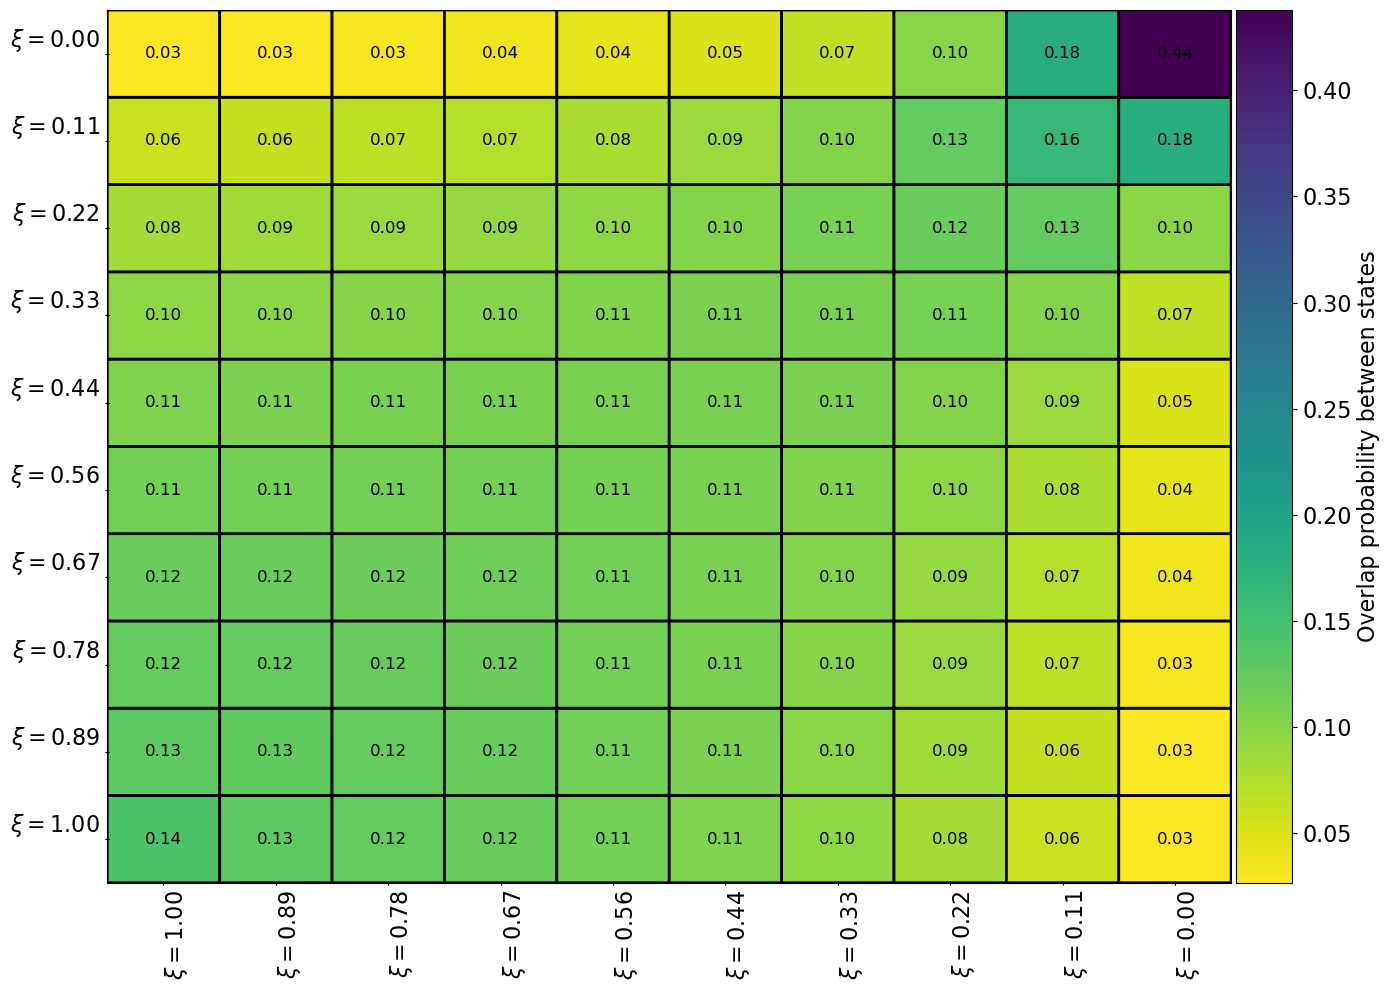

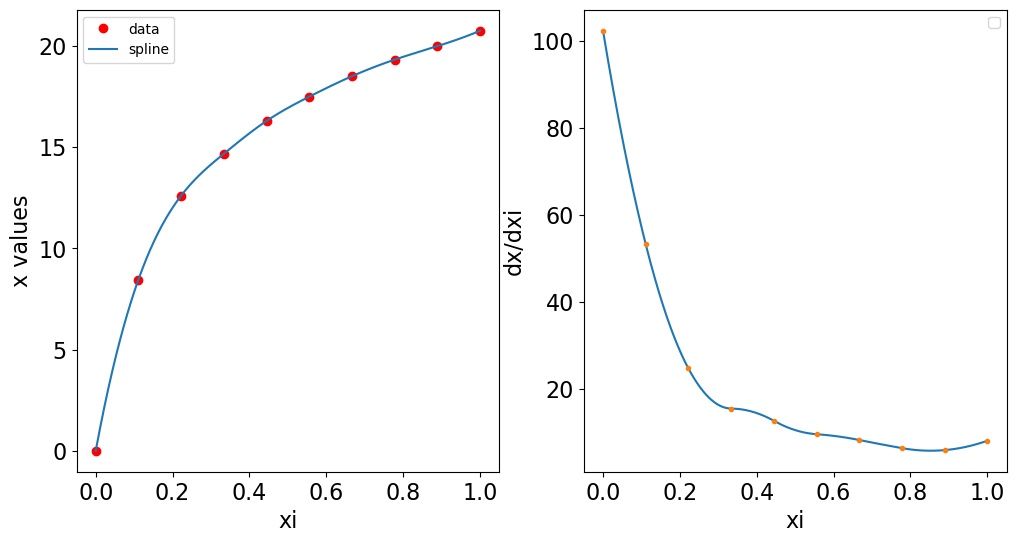

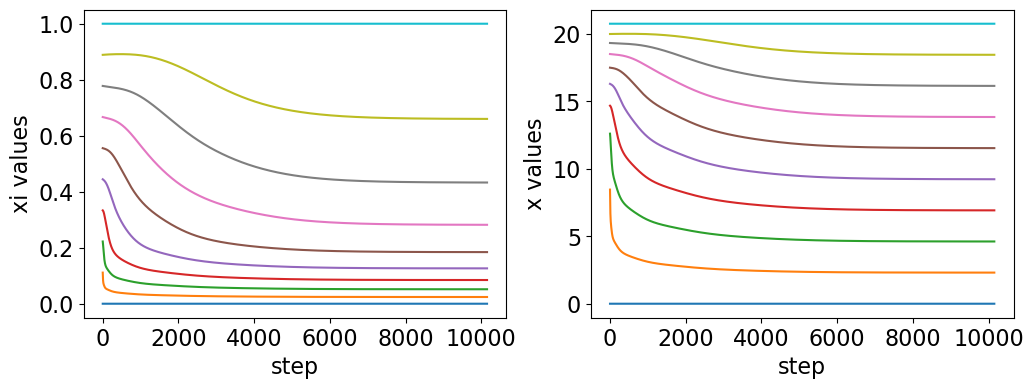

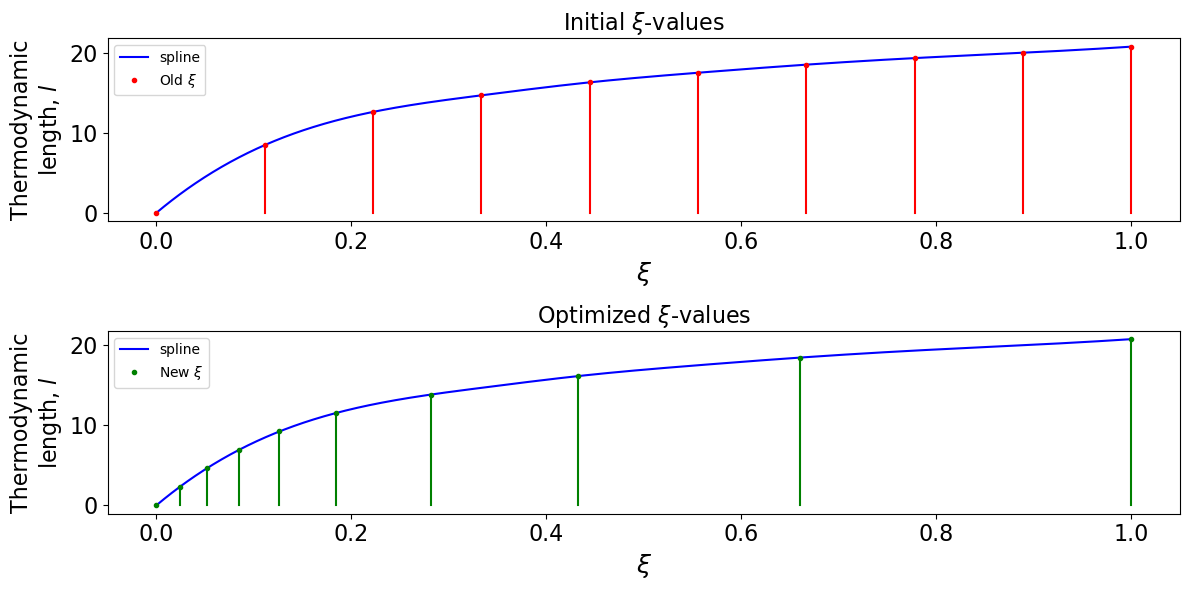

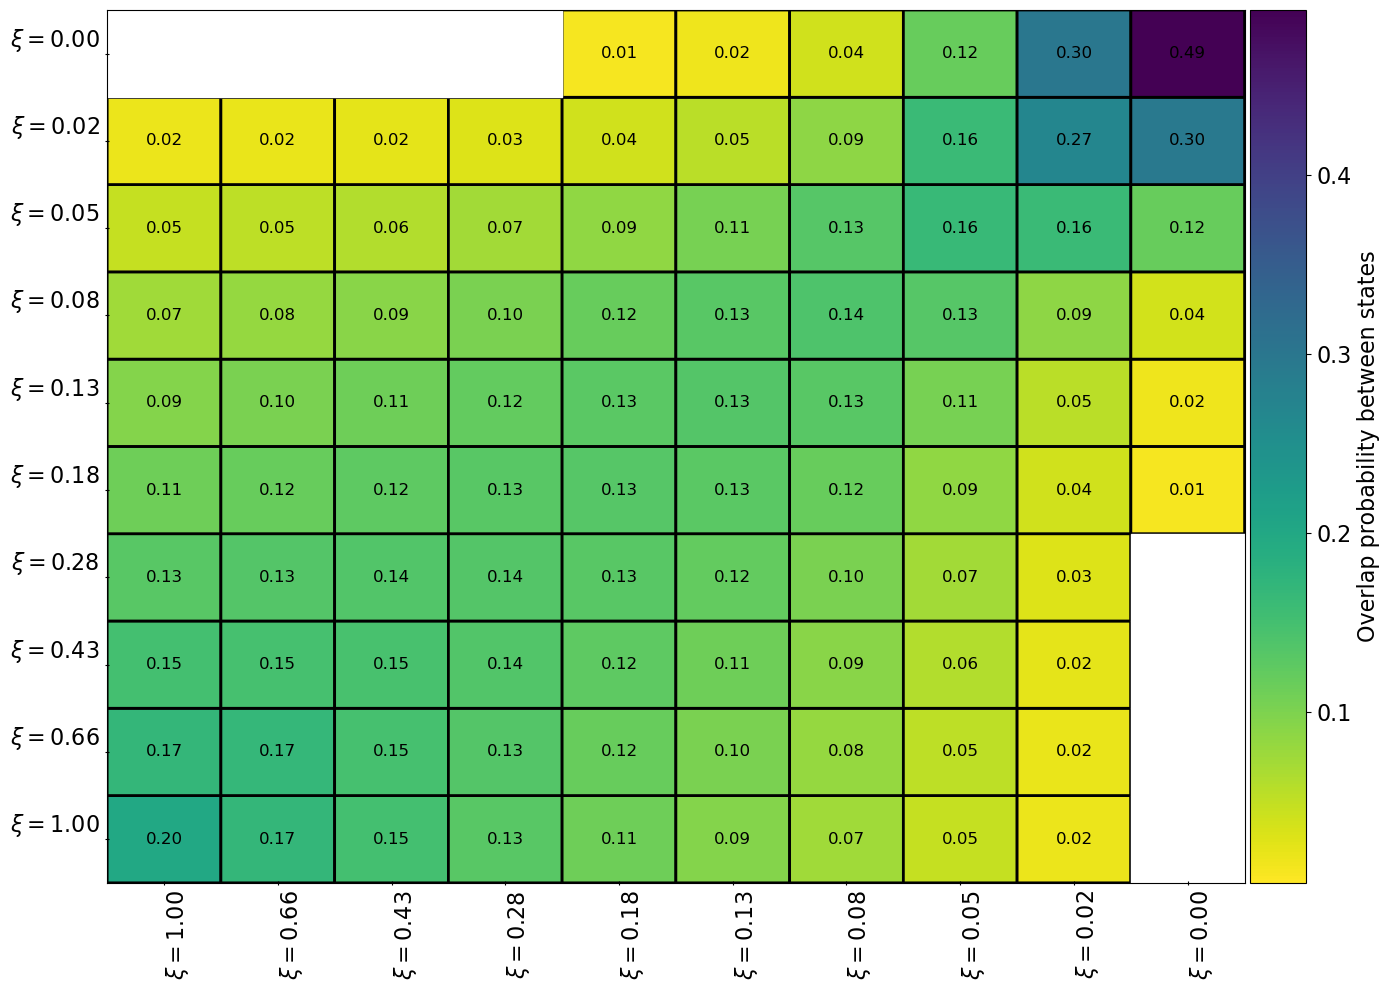

In [17]:
import FwdModelOpt_routines as fmo

_scores = []
figs = []
ensembles,trajs,logZs,results = [],[],[],[]
for i in range(len(energy_perturbations)):

    ####### Data for i'th model #######
    new_energies = energies + energy_perturbations[i]
    new_populations = np.exp(-new_energies)
    new_populations /= new_populations.sum()
    print(f"Prior populations: {new_populations}")
    # Shift the 2nd data point for each state by +1 for each new model
    model_perturbations = np.zeros(forward_model_data.shape)
    model_perturbations[:, 1] = model_perturbations[:, 1]+forward_model_perturbations[i]
    new_forward_model_data = forward_model_data + model_perturbations

    data_dir = dir+f"/NOE_{i}"
    biceps.toolbox.mkdir(data_dir)
    write_noe_files(weights=energies, x=new_forward_model_data, exp=experiment, dir=data_dir)
    input_data = biceps.toolbox.sort_data(data_dir)

    ####### Run MCMC #######
    _ensemble = biceps.ExpandedEnsemble(lambda_values=[lambda_values[0]], energies=new_energies)
    _ensemble.initialize_restraints(input_data, options, verbose=0)

    _PSkwargs = biceps.toolbox.get_PSkwargs()
    _sample_kwargs = biceps.toolbox.get_sample_kwargs()

    _sample_kwargs["progress"] = 0
    _sample_kwargs["verbose"] = 0
    _sample_kwargs["burn"] = 10000
    _sample_kwargs["nsteps"] = nsteps
    _sample_kwargs["attempt_move_fm_prior_sigma_every"] = 0
    _PSkwargs["fmo"] = 0
    _PSkwargs["write_every"] = write_every
    _PSkwargs["xi_integration"] = 1
    _PSkwargs["nreplicas"] = nreplicas
    num_xi_values = 11

    if i == len(energy_perturbations)-1: plot_overlap=True
    else: plot_overlap=False
    score = fmo.xi_integration(_ensemble, _PSkwargs, _sample_kwargs, plot_overlap=plot_overlap, outdir=f"{outdir}",
                   optimize_xi_values=1, xi_opt_steps=2000000, tol=1e-7, alpha=1e-5, progress=1,
                   max_attempts=4, print_every=1000, scale_energies=False, verbose=False)
    _scores.append(score)

    print(f"BICePs score: {score}")


col_name = "BS"
columns = [col for col in df.columns.to_list() if col_name in col]
lam0 = df.iloc[np.where(df["lambda"]==0.0)[0]]
lam0 = lam0[columns]
lam1 = df.iloc[np.where(df["lambda"]==1.0)[0]]
lam1 = lam1[columns]

values = []
for i in range(len(lam0)):
    values.append((lam0.to_numpy()[i]+_scores[i])[0])
    values.append((lam1.to_numpy()[i]+_scores[i])[0])

df["Abs. BS (xi integration w/ xi Opt)"] = values
df.to_csv(f"{outdir}/trial0.csv")


### We've run this notebook 4 additional times ...Taking the mean and standard deviation across 5 trials will show that our $\xi$ integration method with $\xi$ optimization is the favored approach. 

In [25]:
nStates,Nd = 3,2
n_xis,n_lambdas,nreplicas,nsteps,swap_every,write_every=1,2,8,1000000,0,100
files = biceps.toolbox.get_files(outdir+"/trial*.csv")
dfs = []
for file in files:
    dfs.append(pd.read_csv(file, index_col=0))
df = pd.concat(dfs)
grouped = df.groupby(["lambda","xi", "Model"])
mean = grouped.agg("mean")
std = grouped.agg("std")
mean = mean.reset_index()
std = std.reset_index()
mean

,lambda,xi,Model,exp_avg,approx_score,BS,BS w/ ref=Model0,Abs. BS w/ ref=Model0,Abs. BS,Abs. BS (xi integration),Abs. BS (xi integration w/ xi Opt)
0,0.0,1.0,0,5.157637,0.000000,0.000000,0.000000,4.461874,4.461874,4.432710,4.472112
1,0.0,1.0,1,5.882740,0.000000,0.000000,0.685687,5.147561,5.171723,5.132543,5.142387
2,0.0,1.0,2,6.408013,0.000000,0.000000,1.186639,5.648514,5.676844,5.605764,5.679270
3,1.0,1.0,0,4.795220,-0.362417,-0.097081,-0.097263,4.364611,4.365621,4.335629,4.375031
4,1.0,1.0,1,5.584808,-0.297932,-0.069255,0.616255,5.078129,5.102881,5.063289,5.073132
5,1.0,1.0,2,6.142473,-0.265540,-0.054741,1.132262,5.594136,5.622701,5.551023,5.624529


**Table 2. The average BICePs scores over 5 trials for the three models while accounting for the overlap in the distributions.**  Here, we show that the relative BICePs score calculation is far less computational expensive and yields very similar results.  

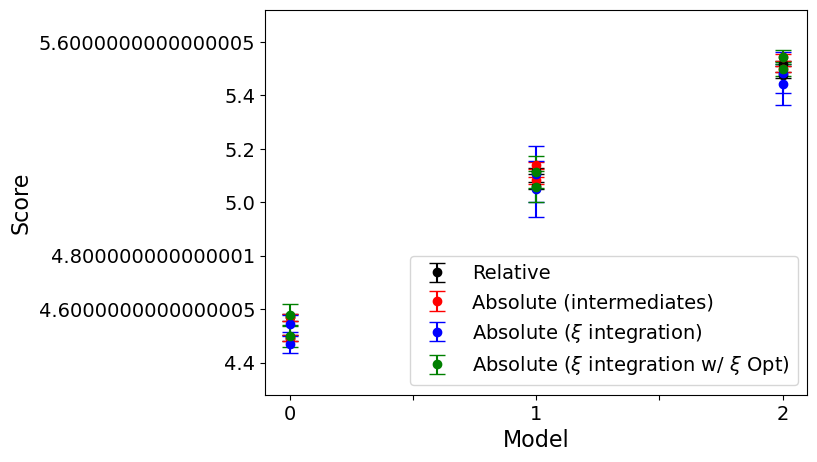

In [26]:
%matplotlib inline
figsize = (7, 5)
label_fontsize=12
legend_fontsize=10
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1, wspace=0.02)
ax = fig.add_subplot(gs[0,0])
if all(np.isnan(std["Abs. BS"].to_numpy())):
    std["Abs. BS w/ ref=Model0"] = np.zeros(std["Abs. BS w/ ref=Model0"].to_numpy().shape)
    std["Abs. BS"] = np.zeros(std["Abs. BS"].to_numpy().shape)
    std["Abs. BS (xi integration)"] = np.zeros(std["Abs. BS (xi integration)"].to_numpy().shape)
    std["Abs. BS (xi integration w/ xi Opt)"] = np.zeros(std["Abs. BS (xi integration w/ xi Opt)"].to_numpy().shape)


ax.errorbar(x=mean["Model"], y=mean["Abs. BS w/ ref=Model0"].to_numpy(), yerr=std["Abs. BS w/ ref=Model0"].to_numpy(),
            color="k", fmt='o', capsize=6, label="Relative")
ax.errorbar(x=mean["Model"], y=mean["Abs. BS"].to_numpy(), yerr=std["Abs. BS"].to_numpy(),
            color="r", fmt='o', capsize=6, label="Absolute (intermediates)")
ax.errorbar(x=mean["Model"], y=mean["Abs. BS (xi integration)"].to_numpy(), yerr=std["Abs. BS (xi integration)"].to_numpy(),
            color="blue", fmt='o', capsize=6, label=r"Absolute ($\xi$ integration)")
ax.errorbar(x=mean["Model"], y=mean["Abs. BS (xi integration w/ xi Opt)"].to_numpy(), yerr=std["Abs. BS (xi integration w/ xi Opt)"].to_numpy(),
            color="green", fmt='o', capsize=6, label=r"Absolute ($\xi$ integration w/ $\xi$ Opt)")
xticks = ax.get_xticks()
xticks = np.array(xticks, dtype=int)
xticks = [str(tick) for tick in xticks]
for i in range(len(xticks)):
    if i%2 != 1: xticks[i] = ""
ax.set_xticklabels(xticks, size=14)
yticks = ax.get_yticks()
ax.set_yticklabels(yticks, size=14)
ax.set_xlabel("Model", fontsize=16)
ax.set_ylabel("Score", fontsize=16)
ax.set_ylim(4.1, 5.9)
legend = ax.legend(fontsize=14)

**Figure 6. The "relative" and "absolute" approaches yield very similar results and are within error.** The error from thermodynamic integration is due to finite sampling.

### Conclusion

Here, we have verified that the results are the same for our “relative score correction” (which we will simply call BICePs scores) and the “extended BICePs scores”. Furthermore, results confirm we only need to calculate the free energy of turning on the data restraints ($\xi=0 \rightarrow 1$) and calculate the free energy of turning on the prior ($\lambda=0 \rightarrow 1$) for the “reference” (lowest energy FF) to convert our “relative scores” to absolute free energies. 



### References

1. Raddi, Robert M. A Bayesian Inference/Maximum Entropy Approach for Optimization and Validation of Empirical Molecular Models. Diss. Temple University,  2024. 31328774. http://dx.doi.org/10.34944/dspace/10681

2. Raddi, Robert M., Marshall, Tim and Voelz, Vincent A.  ‘Automatic Forward Model Parameterization with Bayesian Inference of Conformational Populations’. arXiv Preprint arXiv:2405. 18532, 2024.

3. Dylan Novack, Robert M. Raddi, Si Zhang, Matthew F.D. Hurley and Vincent A. Voelz. "A simple method to optimize the spacing and number of alchemical intermediates in expanded ensemble free energy calculations." J. Chem. Inf. Model. (2025), https://doi.org/10.1021/acs.jcim.5c00704
